# Solid State Analysis for T0

In [1]:
# Standard Packages
import numpy as np
from tifffile import tifffile as tf
import glob
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import os
from pybaselines import Baseline

In [2]:
def get_counts(data_array, plot = False):
    """
    Generates the counts from the given data by summing over the array elements. Returns 2d array of the same dimension as the
    input images.
    
    Arguments:
    
    data_array (numpy.ndarray): Numpy data array containing the diffraction images.
    plot (bool, optional): If set to true, generates a graph of the counts data.
    
    Returns:
    counts (numpy.ndarray): One dimensional numpy array containing the data after summing over each array element.
    
    Example:
    
    data = np.array([[[1, 2, 3], [4, 5, 6]], [[7, 8, 9], [10, 11, 12]]])
    >>>countData(data)
        array([21, 51])
    """
    counts = np.sum(data_array, axis = (1,2))
    if len(data_array) == 0:
        raise ValueError("Input data_array is empty.")
    if data_array.ndim != 3:
        raise ValueError("Input data_array is not 3 dimensional.")
    if plot == True:
        plt.plot(np.arange(len(data_array[:, 0, 0])), counts)
        plt.show()
    return counts

def get_image_details(file_names, sort=True):
    """
    Returns the data loaded from the tif files with a floor subtracted based on the median of the corner. Also returns arrays with the stage 
    positions, the file order number, and the number of counts per image.
    
    Arguments: 
    data_array (numpy.ndarray): Numpy data array containing the diffraction images.
    file_names = ['image001_10.tif', 'image002_20.tif', 'image004_40.tif', 'image003_30.tif', 'image004_40.tif']
    
    Returns:
    data_array (ndarray): Array of N x 1024 x 1024 where N is the length of tile file_names list. Generated by using tifffile as tf.
    stage_pos (array): Default. A numpy array containing the stage positions of the file. The index of each stage position corresponds to
                            the index of the file name in file_names.
    file_order (array): Returns the image number located in the file name. Reflects the order with which the images are taken. 
    counts(ndarray): One dimensional numpy array of length N containing the data after summing over each array element.

    """
    data_array = tf.imread(file_names) # construct array containing files
    
    try:
        stage_pos = []
        file_order = []
        try:
            #stage_pos = [np.float64(file_name[idx_start:idx_end]) for file_name in file_names]
            #stage_pos = np.array(stage_pos)
            for file in file_names:
                string = list(map(str, file.split("/")))
                folder_number = string[9][-3:]
                string = list(map(str, string[-1].split("-")))
                file_number = int(folder_number + string[1])
                file_order.append(int(file_number))
                string = list(map(str, string[-1].split("_")))
                stage_pos.append(float(string[0]))
        except ValueError:
            raise ValueError("""Failed to convert a file name to a float. Make sure that index positions are correct for all files in file_names. 
            Also check separators""")
    except IndexError:
        raise ValueError("Invalid index values. Make sure the index values are within the range of the file name strings.")
    
    stage_pos = np.array(stage_pos)
    file_order = np.array(file_order)
    counts = get_counts(data_array)
    
    if sort == True:
        idx_sort = np.argsort(file_order)
        file_order = file_order[idx_sort]
        data_array = data_array[idx_sort]
        stage_pos = stage_pos[idx_sort]
        counts = counts[idx_sort]
    
    return data_array, stage_pos, file_order, counts 

In [4]:
dataPath = '/work/centurion/shared/UED_data/FY18_o-nitrophenol/20180823/T-zero/20180823_0253/'
#dataPath = '/work/centurion/shared/UED_data/FY18_o-nitrophenol/20180623/T-zero/20180623_2119/'
#dataPath ='/home/centurion/lheald2/GUED_Analysis/GUED_Analysis/data_files/Fluorescence_Data/01102024/fluorescence/scan2/'
runPath = "/*/*/ANDOR1*.tif"

newPath = dataPath + runPath
print(newPath)

files = glob.glob(newPath) 
print(len(files))
data, stage_pos, file_names, counts = get_image_details(files[:])

/work/centurion/shared/UED_data/FY18_o-nitrophenol/20180823/T-zero/20180823_0253//*/*/ANDOR1*.tif
62


In [5]:
np.unique(stage_pos)

array([108.45, 108.5 , 108.55, 108.6 , 108.65, 108.7 , 108.75, 108.8 ,
       108.85])

## Analyze Images

### Average based on Stage Position

In [6]:
uni_stage = np.round(np.unique(stage_pos), decimals=4)
stage_len = len(uni_stage) #  Number of delays

ave_images = []

for i in range(stage_len):
    ave_temp = np.mean(data[np.where(stage_pos==uni_stage[i])[0]], axis = 0);
    ave_images.append(ave_temp)

    
    
ave_images = np.array(ave_images)
print(ave_images.shape)

(9, 1024, 1024)


In [7]:
ref_images = ave_images[0]
diff_images = ave_images-ref_images

KeyboardInterrupt: 

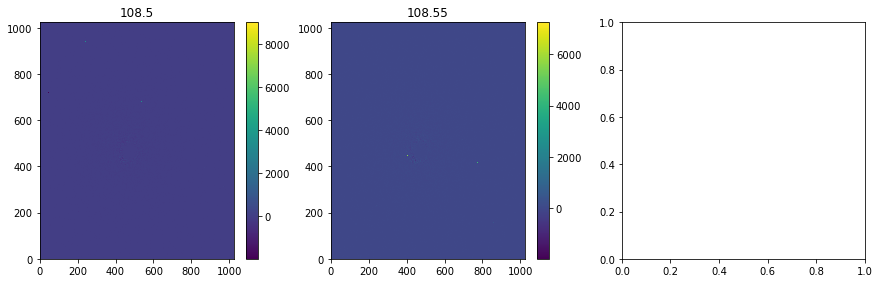

In [8]:
plt.figure(figsize=(20,20))
for i in range(1,len(uni_stage)):
    plt.subplot(4,4,i)
    plt.pcolor(diff_images[i])
    plt.colorbar()
    plt.title(str(uni_stage[i]))

plt.show()

In [ ]:
def normalize_to_baseline(data, posi_1=900, posi_2=1000):
    data_mean = np.nanmean(data, axis=0)
    norm_factor = np.nansum(data_mean[posi_1:posi_2, posi_1:posi_2])
    data_norm = []
    for i in range(len(data)):
        offset = np.nansum(data[i, posi_1:posi_2, posi_1:posi_2])
        norm = data[i]*(norm_factor/offset)
        data_norm.append(norm)
        
    data_norm = np.array(data_norm)
    return data_norm

In [ ]:
norm_data = normalize_to_baseline(data)

ref_images = norm_data[0]
diff_images = (norm_data-ref_images)

plt.figure(figsize=(20,20))
for i in range(1,len(uni_stage)):
    plt.subplot(4,4,i)
    plt.pcolor(diff_images[i])
    plt.colorbar()
    #plt.clim(-0.5,0.5)
    plt.title(str(uni_stage[i]))

plt.show()

## Trim Data

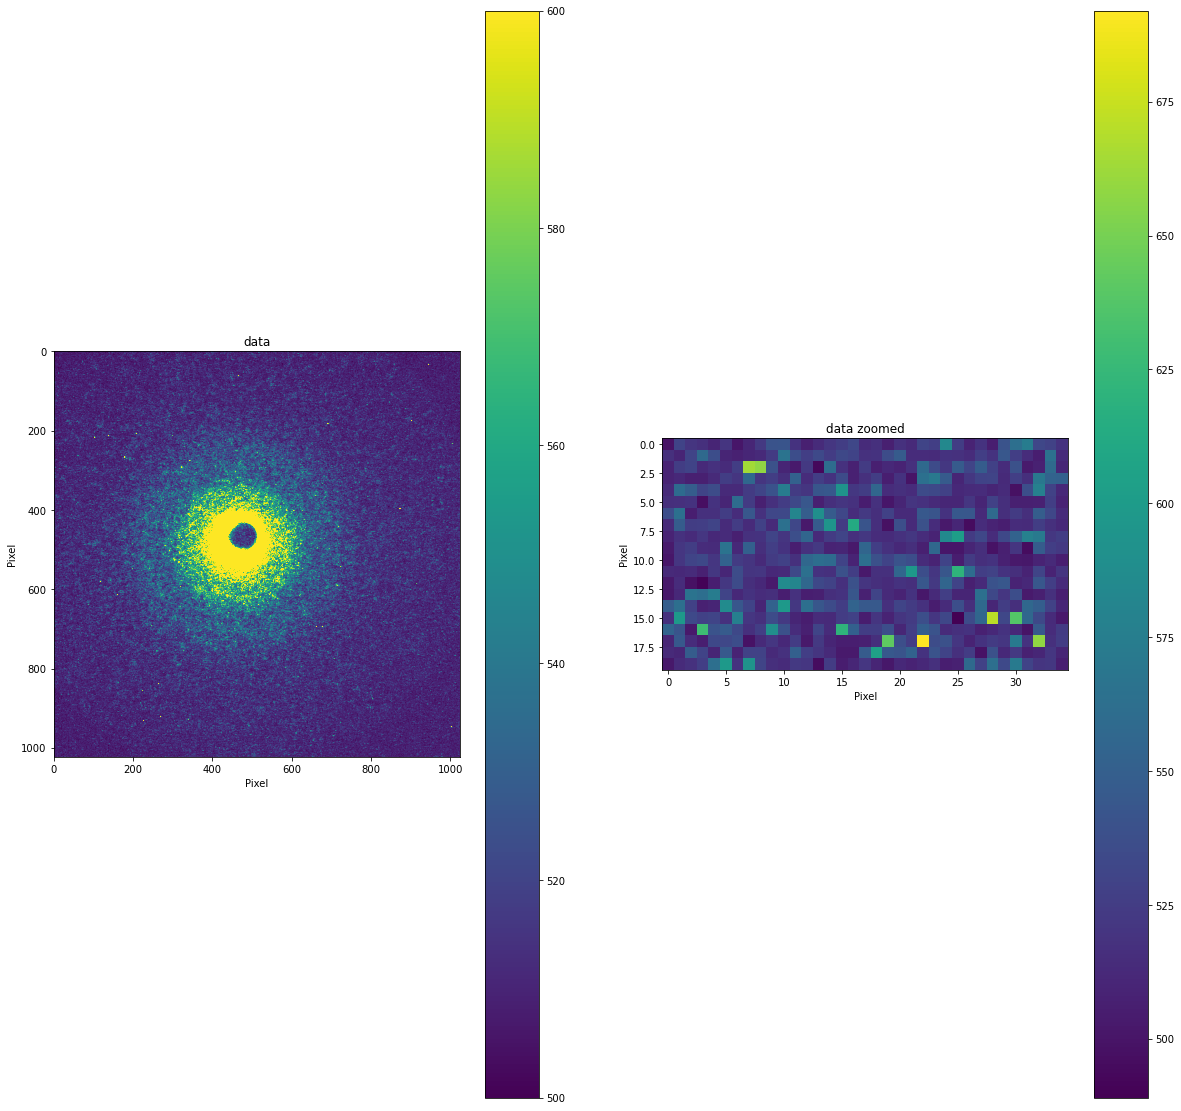

In [10]:
start_1 = 580
stop_1 = 600
start_2 = 635
stop_2 = 670

test=tf.imread(files[0]);
plt.figure(figsize=(20,20))
plt.subplot(1,2,1)
plt.imshow(test)
plt.clim(500, 600)
plt.colorbar()
plt.xlabel('Pixel');
plt.ylabel('Pixel');
plt.title('data')

plt.subplot(1,2,2)
plt.imshow(test[start_1:stop_1, start_2:stop_2]);
plt.colorbar()
plt.xlabel('Pixel');
plt.ylabel('Pixel');
plt.title('data zoomed')
plt.show()

zoomed_data = data[:, start_1:stop_1, start_2:stop_2]

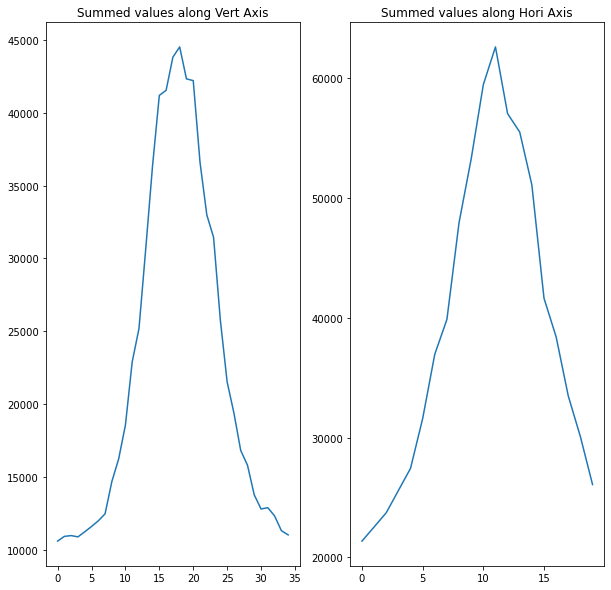

In [95]:
lineout_v = np.sum(zoomed_data, axis=1)
# print(lineout_v.shape)
lineout_h = np.sum(zoomed_data, axis=2)
# print(lineout_h.shape)
sum_total = []

for i in range(len(zoomed_data)):
    sum_temp = np.sum(zoomed_data[i])
    sum_total.append(sum_temp)
    
sum_total = np.array(sum_total)
plt.figure(figsize=(10,10))

plt.subplot(1,2,1)
plt.plot(lineout_v[100])
plt.title("Summed values along Vert Axis")

plt.subplot(1,2,2)
plt.plot(lineout_h[100])
plt.title("Summed values along Hori Axis")
plt.show()

In [96]:
corrected_v = []
corrected_h = []

for i in range(len(lineout_v)):
    baseline_v = np.mean((lineout_v[i, 0], lineout_v[i, -1]))
    baseline_h = np.mean((lineout_h[i, 0], lineout_h[i, -1]))
    temp_v = lineout_v[i] - baseline_v
    temp_h = lineout_h[i] - baseline_h
    corrected_v.append(temp_v)
    corrected_h.append(temp_h)
    
corrected_v = np.array(corrected_v)
corrected_h = np.array(corrected_h)

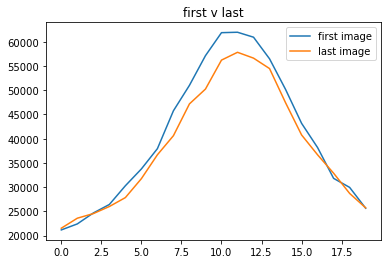

In [97]:
plt.figure()
plt.plot(lineout_h[0], label="first image")
plt.plot(lineout_h[-1], label="last image")
plt.title("first v last")
plt.legend()
plt.show()


## Average Based on Stage

In [98]:
uni_stage = np.round(np.unique(stage_pos), decimals=4)
stage_len = len(uni_stage) #  Number of delays

ave_data_h = []
ave_data_v = []
sum_data = []

for i in range(stage_len):
    ave_h = np.mean(corrected_h[np.where(stage_pos==uni_stage[i])[0]], axis = 0);
    ave_data_h.append(ave_h)
    ave_v = np.mean(corrected_v[np.where(stage_pos==uni_stage[i])[0]], axis = 0);
    ave_data_v.append(ave_v)
    sum_temp = np.mean(sum_total[np.where(stage_pos==uni_stage[i])[0]], axis=0)
    sum_data.append(sum_temp)
    
    
ave_data_h = np.array(ave_data_h)
ave_data_v = np.array(ave_data_v)
sum_data = np.array(sum_data)/max(sum_data)
print(ave_data_h.shape)
print(ave_data_v.shape)
print(sum_data.shape)

(11, 20)
(11, 35)
(11,)


## Plot Data

<ipython-input-99-0fdb8a9785a2>:9: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(uni_stage, pixels_v, ave_data_v.T, cmap="bwr")
<ipython-input-99-0fdb8a9785a2>:18: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(uni_stage, pixels_h, ave_data_h.T, cmap="bwr")
<ipython-input-99-0fdb8a9785a2>:28: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the

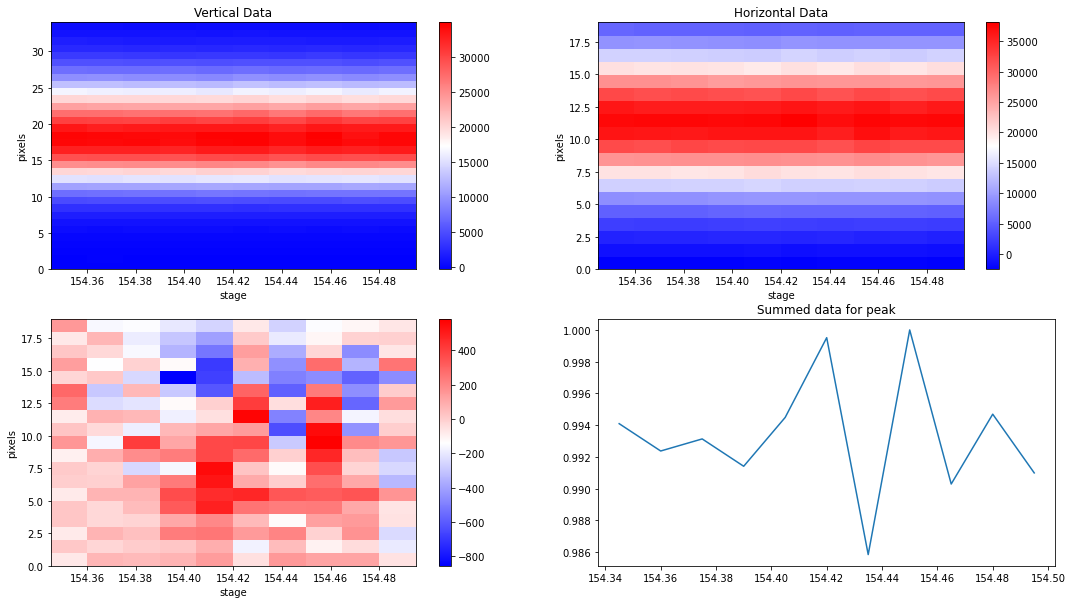

In [99]:
pixels_h = np.arange(0,len(ave_data_h[0]),1)
pixels_v = np.arange(0, len(ave_data_v[0]),1)

ref = np.nanmean(ave_data_h[:2], axis=0)
h_norm = ave_data_h-ref; # Calculate the percentage difference signal

plt.figure(figsize=(18,10))
plt.subplot(2,2,1)
plt.pcolor(uni_stage, pixels_v, ave_data_v.T, cmap="bwr")
# plt.clim(vmin=-2000, vmax=2000)
# plt.xlim(26.8, 27.4)
plt.ylabel("pixels")
plt.xlabel("stage")
plt.title("Vertical Data")
plt.colorbar()

plt.subplot(2,2,2,)
plt.pcolor(uni_stage, pixels_h, ave_data_h.T, cmap="bwr")
# plt.clim(vmin=-10000, vmax=10000)
# plt.xlim(26.8, 27.4)
#plt.ylim(10,60)
plt.ylabel("pixels")
plt.xlabel("stage")
plt.title("Horizontal Data")
plt.colorbar()

plt.subplot(2,2,3)
plt.pcolor(uni_stage, pixels_h, h_norm.T, cmap="bwr")
plt.colorbar()
#plt.clim(-1,1)
# plt.xlim(26.8, 27.4)
# plt.ylim(10, 70)
plt.ylabel("pixels")
plt.xlabel("stage")

plt.subplot(2,2,4)
plt.plot(uni_stage, sum_data)
plt.title("Summed data for peak")
plt.show()